# Imports and Setting Seed


In [ ]:
#For the use of google colab. Connects to google drive, which acts as storage for loading files, data, and models. Comment this out if not using google colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Also for use of google colab. Imports packages that google colab does not have preinstalled.
!pip3 install segmentation_models_pytorch
!pip3 install warmup_scheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [ ]:
#Import packages

import torch.utils.data as Data
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as smp_losses
import segmentation_models_pytorch.utils as smp_utils
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import datetime
import random
import sys
from torch.optim.lr_scheduler import StepLR
from warmup_scheduler import GradualWarmupScheduler
from copy import deepcopy
import torchvision.utils as vutils
import ssl
import pickle

In [ ]:

#Define GPU use
torch.set_num_threads(6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Define set seed

seed_cus = 1

random.seed(seed_cus)
np.random.seed(seed_cus)
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_cus)



# Load Data

In [ ]:
def concatenate_images(frames, select_frame_method, img_list, transform1):
  '''Generates the indices out of 30 that need to be concatenated and concatenates them'''

  #These are chosen for every nth frame, where n = 30/number of frames
  #These values could change arbitrarily
  #NOTE: 20 frames is experimental using a technique where the frames in the beginning and end are skipped and the middle frames are preserved with the logic being that the middle frames will contain more information. This logic could be faulty and is subject to change as with all other indices - these are just some preset settings
  chosen_frames_dict = {
    5: [0,6,12,18,24],
    10: [0,3,6,9,12,15,18,21,24,27],
    15: [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28],
    20: [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
  }


  if frames == 30:
    indices = range(0, 30)
    return concat(img_list, indices, transform1)


  elif frames < 30 and frames > 0:

    if select_frame_method == 'consecutive':
      indices = range(0, frames)
      return concat(img_list, indices, transform1)

    elif select_frame_method == 'specific':

      if frames in chosen_frames_dict:
        indices = chosen_frames_dict[frames]
        return concat(img_list, indices, transform1)
      else:
        print("Invalid number of frames for the specific frame selection method. Please input 5, 10, 15, 20, or 30.")

    else:
      print("Invalid frame selection method. Please select either consecutive or specific. Consecutive chooses a random starting point and takes the next X number of frames, where X is the number of frames inputted.")
      print("The specific frame selection method takes in the number of frames chosen and chooses every 30/Xth frames. So if 10 frames are chosen with the specific frame selection method every 30/10 = 3rd frame is chosen.")



  else:
    print("Invalid frame number. Number of frames selected should be between 1 and 30. Please input a valid number of frames.")

In [ ]:
def concat(img_list, indices, transform1):
  '''Concatenates images together given a list of indices'''
  starting_index = indices[0]
  first_img = img_list[starting_index]
  tuned = first_img/[255.0]
  tuned = cv2.resize(tuned,(224,224))
  tuned = tuned.astype(np.float32)
  tuned = transform1(tuned)

  combined_imgs = tuned.unsqueeze(0)


  for i in indices[1:]:
    img = img_list[i]
    LABImg = img/[255.0]
    LABImg = cv2.resize(LABImg,(224,224))
    LABImg = LABImg.astype(np.float32)
    LABImg = transform1(LABImg)
    combined_imgs = torch.cat((combined_imgs, LABImg.unsqueeze(0)), 0)


  return combined_imgs

In [ ]:
#Define dataset class

import torch.utils.data as Data
class My_Datasets(Data.Dataset):
    def __init__(self, img_dir, mask_dir, frames, select_frame_method, transform1=None,transform2=None):
        super().__init__()
        #Set paths to the Cine and mask directory
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        #Get a list of all the files in the Cine and mask directories
        self.img_list = os.listdir(self.img_dir)
        self.mask_list = os.listdir(self.mask_dir)

        #Initialize transforms
        self.transform1 = transform1
        self.transform2 = transform2

        #Define number of frames and how those frames are chosen(consecutive or specific)
        self.frames = frames
        self.select_frame_method = select_frame_method

    def __getitem__(self, index):

        #Define the Cine file name
        img_name = self.img_list[index]

        #Define the mask file name using the Cine file name so the masks and the Cine images match up
        mask_name = self.img_list[index].split('.')[0] + ".nii.png"

        #Read the .tiff file with 30 pages using cv2.imreadmulti instead of cv2.imread
        img_tuple = cv2.imreadmulti(os.path.join(self.img_dir,img_name), flags = cv2.IMREAD_COLOR) # here we load as RBG

        #cv2.imreadmulti returns a tuple of length two, with the second value of the tuple being the actual images
        img_list = img_tuple[1]

        #Concatenate images based on specific indices, which are defined above but are subject to change
        combined_imgs = concatenate_images(self.frames, self.select_frame_method, img_list, self.transform1)


        #Perform necessary operations on the mask
        mask= cv2.imread(os.path.join(self.mask_dir,mask_name)) # here we load as RBG
        #Note here that mask is divided by 1 instead of 255 because the masks values range from 0-3 instead of 0-255 like the LGE/Cine images
        LABmask = mask/[1.0]
        LABmask = cv2.resize(LABmask,(224,224))
        LABmask = LABmask.astype(np.float32)
        LABmask = LABmask[:,:,0]
        LABmask = self.transform2(LABmask)

        return combined_imgs, LABmask, img_name

    def __len__(self):
        return len(self.img_list)


#Define transforms

transforms_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
transforms_mask = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Define batch size, image paths, and create an object of the dataset class made above

img_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/Cine/'
mask_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/masks/'


batch_size_train = 2
batch_size_val = 1

#Change number of frames and the method of selecting them here
number_of_frames = 5

#Options: 'consecutive' or 'specific'
#Consecutive starts from the beginning index and takes the next X number of frames, where X is the variable defined above: number_of_frames
#Specific works in conjunction with number_of_frames. Available options for number_of_frames are 5, 10, 15, 20, 30
#Specific will take every nth frame, where n is 30/number_of_frames. For example, with 10 frames selected the specific frame selection method will take every 3rd frame
select_frames_method = 'specific'

train_set = My_Datasets(img_path,mask_path, number_of_frames, select_frames_method, transform1=transforms_img,transform2=transforms_mask)
n_train = len(train_set)
split = n_train // 5
a = list(range(n_train))

In [ ]:
#Confirm that the first value is equal to number_of_frames
train_set[0][0].shape

torch.Size([5, 3, 224, 224])

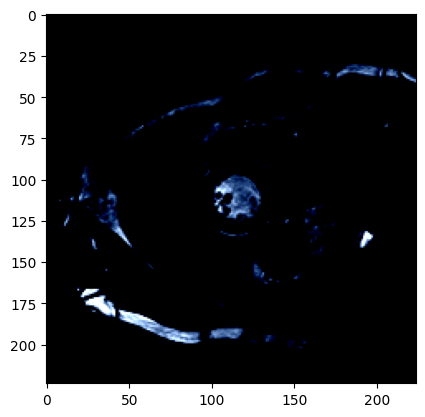

In [ ]:
#Show image for confirmation that it is not corrupted
plt.imshow(train_set[0][0][0].permute(1,2,0))

In [ ]:
#Name to check back with the original data
train_set[0][2]

'266_1_0000.nii.tiff'

In [ ]:
#Load pickle files with indices meant for training vs testing

with open('/content/drive/My Drive/Internship_24_Ryan/Heart/Indices/train_indices.pkl', 'rb') as f:
  train_indices = pickle.load(f)

with open('/content/drive/My Drive/Internship_24_Ryan/Heart/Indices/val_indices.pkl', 'rb') as f:
  val_indices = pickle.load(f)



In [ ]:
# #Load test set

# img_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
# mask_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

# test_set_phx = My_Datasets(img_path_test, mask_path_test, transform1=transforms_img, transform2=transforms_mask, frames = 30, select_frame_method = 'specific')

# test_indices = range(0, len(test_set_phx))

# test_sampler

# test_loader = Data.DataLoader(dataset=test_set_phx, num_workers=0,batch_size=1,pin_memory=True, worker_init_fn=seed_worker, generator=g)

In [ ]:
# len(test_set_phx)

In [ ]:
# define fixed seed
random.seed(seed_cus)
# define fixed seed
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)
indices = random.sample(a, len(a))

#Given a list of indices meant for training, create a Dataloader that will create a training set and batches
#Do the same for validation as well


train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)

# define fixed seed
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)

valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = Data.DataLoader(
    dataset=train_set,
    sampler=train_sampler,
    num_workers=0,
    batch_size=batch_size_train,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g)


valid_loader = Data.DataLoader(
    dataset=train_set,
    sampler=valid_sampler,
    num_workers=0,
    batch_size=batch_size_val,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g)




# Loading Custom 2D + 1D Model

In [ ]:
#Loads a one dimensional convolution layer. Has a unique input "frames" that changes the one dimensional layer based on the number of frames.
class OneD(nn.Module):
    def __init__(self, in_channels, out_channels, frames):
        super().__init__()

        if frames == 30:
          self.one = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 5, stride = 5, padding = 0),
            nn.ReLU(),

            nn.Conv1d(out_channels, out_channels, 3, stride = 3, padding = 0),
            nn.ReLU(),

            nn.Conv1d(out_channels, out_channels, 2, stride = 2, padding = 0),
            nn.ReLU(),

          )
        elif frames == 20:
          self.one = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 5, stride = 5, padding = 0),
            nn.ReLU(),

            nn.Conv1d(out_channels, out_channels, 4, stride = 4, padding = 0),
            nn.ReLU(),

          )
        elif frames == 15:
          self.one = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 5, stride = 5, padding = 0),
            nn.ReLU(),

            nn.Conv1d(out_channels, out_channels, 3, stride = 3, padding = 0),
            nn.ReLU(),

          )
        elif frames == 10:
          self.one = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 5, stride = 5, padding = 0),
            nn.ReLU(),

            nn.Conv1d(out_channels, out_channels, 2, stride = 2, padding = 0),
            nn.ReLU(),

          )
        elif frames == 5:
          self.one = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 5, stride = 5, padding = 0),
            nn.ReLU(),

          )



    def forward(self, x):
        return self.one(x)

In [ ]:
def compress2(stacked_outputs, block):
        #Input shape is (n_frames, batch_size, channels, n, n). Ensure that block has an in_channels of one and and out_channels of n*n
        #print("Input: ", stacked_outputs.shape)

        #Step 1: Swap axes. Output shape: (batch_size, n*n, n_frames, channels)
        reshaped_output0 = stacked_outputs.permute(1, 3, 4, 0, 2).flatten(1, 2)
        #print("Layer 1 Output Shape: ", reshaped_output0.shape)


        #Step 2: Reorder channels so that the first 30 channels, or however many frames, are the first channel from the 30 frames. Output shape: (batch_size, n*n, n_frames * channels)
        batch_size = reshaped_output0.shape[0]
        n_n = reshaped_output0.shape[1]
        reordered_output = reshaped_output0.permute(0,1,3,2).contiguous().view(batch_size, n_n, -1)
        #print("Layer 2 Output Shape: ", reordered_output.shape)


        #Step 3: Flatten with an output shape of (batch_size, 1, n*n * channels * n_frames)
        flattened_output = reordered_output.flatten(1,2).unsqueeze(1)
        #print("Layer 3 Output Shape: ", flattened_output.shape)


        #Step 4: Apply one dimensional block. Output shape is (batch_size, n*n ,n*n * channels)
        compressed_image = block(flattened_output)
        #print("Layer 4 Output Shape: ", compressed_image.shape)

        #Step 5: Average layers
        channel_dim = 1
        averaged_img = compressed_image.mean(channel_dim).squeeze(channel_dim)

        #print("Layer 5 Output Shape: ", averaged_img.shape)

        #Step 6: Reshape the input shape of (batch_size, 1, n*n * channels) to (batch_size, channels, n, n)

        n = stacked_outputs.shape[-1]
        channels = stacked_outputs.shape[-3]

        #6.1: Reshape (batch_size, 1, n*n * channels) to (batch_size, n*n, channels) using unflatten
        final_output = averaged_img.unflatten(-1, (n*n, channels))

        #print("Layer 6.1 Output Shape: ", final_output.shape)

        #6.2: Reshape (batch_size, n*n, channels) to (batch_size, n, n, channels) using unflatten
        final_output = final_output.unflatten(1, (n, n))

        #print("Layer 6.2 Output Shape: ", final_output.shape)

        #6.3: Reshape (batch_size, n, n, channels) to (batch_size, channels, n, n) using permute
        final_output = final_output.permute(0, 3, 1, 2)

        #print("Layer 6.3 Output Shape: ", final_output.shape)


        #Return outputs from each step
        return final_output

In [ ]:
#The below code is copied from the segmentation_models_pytorch library.
#Modifications to the SMP library happen solely in the SegmentationModel class
#Besides the SegmentationModel class, if confused refer to the library documentation

In [ ]:
import json
from pathlib import Path
from typing import Optional, Union
from functools import wraps
from huggingface_hub import (
    PyTorchModelHubMixin,
    ModelCard,
    ModelCardData,
    hf_hub_download,
)


MODEL_CARD = """
---
{{ card_data }}
---
# {{ model_name }} Model Card

Table of Contents:
- [Load trained model](#load-trained-model)
- [Model init parameters](#model-init-parameters)
- [Model metrics](#model-metrics)
- [Dataset](#dataset)

## Load trained model
```python
import segmentation_models_pytorch as smp

model = smp.{{ model_name }}.from_pretrained("{{ save_directory | default("<save-directory-or-repo>", true)}}")
```

## Model init parameters
```python
model_init_params = {{ model_parameters }}
```

## Model metrics
{{ metrics | default("[More Information Needed]", true) }}

## Dataset
Dataset name: {{ dataset | default("[More Information Needed]", true) }}

## More Information
- Library: {{ repo_url | default("[More Information Needed]", true) }}
- Docs: {{ docs_url | default("[More Information Needed]", true) }}

This model has been pushed to the Hub using the [PytorchModelHubMixin](https://huggingface.co/docs/huggingface_hub/package_reference/mixins#huggingface_hub.PyTorchModelHubMixin)
"""


def _format_parameters(parameters: dict):
    params = {k: v for k, v in parameters.items() if not k.startswith("_")}
    params = [
        f'"{k}": {v}' if not isinstance(v, str) else f'"{k}": "{v}"'
        for k, v in params.items()
    ]
    params = ",\n".join([f"    {param}" for param in params])
    params = "{\n" + f"{params}" + "\n}"
    return params


class SMPHubMixin(PyTorchModelHubMixin):
    def generate_model_card(self, *args, **kwargs) -> ModelCard:
        model_parameters_json = _format_parameters(self._hub_mixin_config)
        directory = self._save_directory if hasattr(self, "_save_directory") else None
        repo_id = self._repo_id if hasattr(self, "_repo_id") else None
        repo_or_directory = repo_id if repo_id is not None else directory

        metrics = self._metrics if hasattr(self, "_metrics") else None
        dataset = self._dataset if hasattr(self, "_dataset") else None

        if metrics is not None:
            metrics = json.dumps(metrics, indent=4)
            metrics = f"```json\n{metrics}\n```"

        model_card_data = ModelCardData(
            languages=["python"],
            library_name="segmentation-models-pytorch",
            license="mit",
            tags=["semantic-segmentation", "pytorch", "segmentation-models-pytorch"],
            pipeline_tag="image-segmentation",
        )
        model_card = ModelCard.from_template(
            card_data=model_card_data,
            template_str=MODEL_CARD,
            repo_url="https://github.com/qubvel/segmentation_models.pytorch",
            docs_url="https://smp.readthedocs.io/en/latest/",
            model_parameters=model_parameters_json,
            save_directory=repo_or_directory,
            model_name=self.__class__.__name__,
            metrics=metrics,
            dataset=dataset,
        )
        return model_card

    def _set_attrs_from_kwargs(self, attrs, kwargs):
        for attr in attrs:
            if attr in kwargs:
                setattr(self, f"_{attr}", kwargs.pop(attr))

    def _del_attrs(self, attrs):
        for attr in attrs:
            if hasattr(self, f"_{attr}"):
                delattr(self, f"_{attr}")

    @wraps(PyTorchModelHubMixin.save_pretrained)
    def save_pretrained(
        self, save_directory: Union[str, Path], *args, **kwargs
    ) -> Optional[str]:
        # set additional attributes to be used in generate_model_card
        self._save_directory = save_directory
        self._set_attrs_from_kwargs(["metrics", "dataset"], kwargs)

        # set additional attribute to be used in from_pretrained
        self._hub_mixin_config["_model_class"] = self.__class__.__name__

        try:
            # call the original save_pretrained
            result = super().save_pretrained(save_directory, *args, **kwargs)
        finally:
            # delete the additional attributes
            self._del_attrs(["save_directory", "metrics", "dataset"])
            self._hub_mixin_config.pop("_model_class")

        return result

    @wraps(PyTorchModelHubMixin.push_to_hub)
    def push_to_hub(self, repo_id: str, *args, **kwargs):
        self._repo_id = repo_id
        self._set_attrs_from_kwargs(["metrics", "dataset"], kwargs)
        result = super().push_to_hub(repo_id, *args, **kwargs)
        self._del_attrs(["repo_id", "metrics", "dataset"])
        return result

    @property
    def config(self):
        return self._hub_mixin_config


@wraps(PyTorchModelHubMixin.from_pretrained)
def from_pretrained(pretrained_model_name_or_path: str, *args, **kwargs):
    config_path = hf_hub_download(
        pretrained_model_name_or_path,
        filename="config.json",
        revision=kwargs.get("revision", None),
    )
    with open(config_path, "r") as f:
        config = json.load(f)
    model_class_name = config.pop("_model_class")

    import segmentation_models_pytorch as smp

    model_class = getattr(smp, model_class_name)
    return model_class.from_pretrained(pretrained_model_name_or_path, *args, **kwargs)

In [ ]:
def initialize_decoder(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def initialize_head(module):
    for m in module.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
import torch

#This is the only section of the model code that has been custom coded - everything else is just what's needed from the SMP library
class SegmentationModel(torch.nn.Module, SMPHubMixin):
    def initialize(self):

        #Define decoders and segmentation head
        initialize_decoder(self.decoder)
        initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            initialize_head(self.classification_head)

        #Create the one dimensional layers, with more output channels the more pixels the output has.
          #At the first 1D layer, there will only be 49 pixels(7x7), so less output channels are needed
          #Ideally, every step up should require x4 channels, but due to RAM limitations with 22.5GB, this was not possible
        self.oned1 = OneD(1,2, number_of_frames)
        self.oned2 = OneD(1,5, number_of_frames)
        self.oned3 = OneD(1,10, number_of_frames)
        self.oned4 = OneD(1,20, number_of_frames)
        self.oned5 = OneD(1,40, number_of_frames)

        self.onedlayers = []
        self.onedlayers.append(self.oned1)
        self.onedlayers.append(self.oned2)
        self.onedlayers.append(self.oned3)
        self.onedlayers.append(self.oned4)
        self.onedlayers.append(self.oned5)



    def check_input_shape(self, x):
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (
                (h // output_stride + 1) * output_stride
                if h % output_stride != 0
                else h
            )
            new_w = (
                (w // output_stride + 1) * output_stride
                if w % output_stride != 0
                else w
            )
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""
        compressed_features = []


        #The first layer of the skip connection gets ignored, but in order for the indexing later on to work, the feature output needs an empty first output
        compressed_features.append(["EMPTY"])

        #Go through each frame of the image and add the output features to a list
        features_list = []
        if len(x) > 1:
          for img in x:
            self.check_input_shape(img)
            features = self.encoder(img)
            features_list.append(features)


          #Goes through each layer and gets the output from that layer from all of the feature outputs
          for index in range(1, 6):

            layer_output = []

            #print(layer_output.shape)

            for outputs in features_list:

              image_output = outputs[index]

              layer_output.append(image_output)

            layer_output = torch.stack(layer_output)

            #Define the 1D block with correct number of output channels
            block = self.onedlayers[index - 1]


            #Applies compress function to resize and reorder channels - refer back up to the documentation of compress2 for more info
            compressed_output = compress2(layer_output, block)

            compressed_features.append(compressed_output)


          #Send the compressed features up the decoder
          decoder_output = self.decoder(*compressed_features)

          #Apply segmentation head and return the prediction
          masks = self.segmentation_head(decoder_output)

          return masks




    @torch.no_grad()
    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        x = self.forward(x)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md


class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(
            attention_type, in_channels=in_channels + skip_channels
        )
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None

            #print(x.shape)
            #print(skip.shape)
            x = decoder_block(x, skip)

        return x

In [ ]:
from typing import Optional, Union, List

from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationHead,
    ClassificationHead,
)


class Unet(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()

In [ ]:
#Load model

ssl._create_default_https_context = ssl._create_unverified_context
model_phx = Unet('resnet50',encoder_weights='imagenet', in_channels=3, classes=4)

model_phx= nn.DataParallel(model_phx)
model_phx.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


DataParallel(
  (module): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

# Define Training

In [ ]:
#Define training

def train(epoch, alpha, beta):
    loss_sum = 0
    prev_time = time.time()
    for i, (images, masks, names) in enumerate(train_loader):

        #The images are originally of shape (batch_size, frames, channels, pixels, pixels)
          #However want to switch this for the model, as compress2 takes in shape (frames, batch_size, channels, pixels, pixels)
        images = images.permute(1, 0, 2, 3, 4)

        #Send imgs and masks to GPU
        imgs = images.to(device=device,dtype=torch.float32)
        masks = masks.to(device=device,dtype=torch.float32)

        #Converts mask type to LongTensor
          #This fixes an error, but not sure why type LongTensor is needed
        masks = masks.long()

        #Use model to predict on the images
        masks_pred = model_phx(imgs)

        #Calculate loss
        loss_seg = alpha * criterion_FA(masks_pred, masks)
        loss_all = loss_seg
        iter_loss = loss_all.data.item()
        loss_sum += loss_all.item()

        #Calculate gradients and begin backwards propagation
        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()


        #Print output of each batch and epoch
        batches_done = epoch * len(train_loader) + i
        batches_left = num_epoch * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [loss_seg: %f] [loss: %f]  ETA: %s"
            % (
                epoch,
                num_epoch,
                i,
                len(train_loader),
                loss_seg.item(),
                loss_all.item(),
                time_left,
            )
        )


#Define validation
def val(epoch, alpha, beta):
    #Define variables
    loss_sum = 0
    global best_seg_loss
    running_loss_all = 0.0
    running_loss_seg = 0.0
    prev_time = time.time()

    for i, (images, masks, names) in enumerate(valid_loader):
        #Same reason for permutation as above
        images = images.permute(1, 0, 2, 3, 4)

        #Send img/mask to GPU
        imgs = images.to(device=device,dtype=torch.float32)
        masks = masks.to(device=device,dtype=torch.float32)

        batch_size = imgs.shape[1]

        #Again, fixes an error
        masks = masks.long()

        with torch.no_grad():
            #Set to eval so weights don't change
            model_phx.eval()

            #Predict
            masks_pred = model_phx(imgs)

            #Calculate loss
            loss_seg = alpha * criterion_FA(masks_pred, masks)
            loss_all = loss_seg
            iter_loss = loss_all.data.item()
            loss_sum += loss_all.item()
            running_loss_seg += loss_seg.item() * batch_size
            running_loss_all += loss_all.item() * batch_size

            #Print output loss for the validation stage of an epoch
            batches_done = epoch * len(valid_loader) + i
            batches_left = num_epoch * len(valid_loader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [loss_seg: %f] [loss: %f]  ETA: %s"
            % (
                epoch,
                num_epoch,
                i,
                len(valid_loader),
                loss_seg.item(),
                loss_all.item(),
                time_left,
            )
        )

    # len of valid_loader here is the total number of image, thus divided by 10
    epoch_loss_seg = running_loss_seg / (len(valid_loader.dataset)/5)
    epoch_loss_all = running_loss_all / (len(valid_loader.dataset)/5)

    # skip one line
    keyword = os.linesep
    print(keyword)

    sys.stdout.write(
        "[Epoch %d/%d] [loss_seg: %f] [loss: %f]"
        % (
            epoch,
            num_epoch,
            epoch_loss_seg,
            epoch_loss_all,
#                    time_left,
        )
    )

    epoch_loss_seg_adj = epoch_loss_seg/alpha
    if epoch_loss_seg_adj < best_seg_loss:
        best_seg_loss = epoch_loss_seg_adj
#                best_epoch = epoch
        torch.save(model_phx.state_dict(), '/content/drive/My Drive/Internship_24_Ryan/Heart/Models/two_plus_one_resnet50_baseline.pt')




In [ ]:
# Define training parameters here
# Experiment with different losses, optimizers, learning rate, epochs
# Adam and dice loss in general were found to be the best

num_epoch = 35
learning_rate = 1e-4

criterion_FA = smp_losses.dice.DiceLoss(smp_losses.MULTICLASS_MODE, from_logits=True) # new loss (multi) in losses
optimizer = optim.Adam(model_phx.parameters(),
                           lr=learning_rate)

scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=2, total_epoch=5, after_scheduler=scheduler_cosine)
device = torch.device('cuda')

# Training

In [ ]:
#Training


#Send loss to GPU
criterion_FA = criterion_FA.cuda()

#Used for loss, not important
alpha = 1.0
beta = 0.0


best_seg_loss = 999999
for epoch in range(num_epoch):
    print('Starting training epoch {}/{}.'.format(epoch + 1, num_epoch))
    model_phx.train()
    train(epoch, alpha, beta)
    scheduler_warmup.step()
    print(scheduler_warmup.get_lr())
    print('Starting validation epoch {}/{}.'.format(epoch + 1, num_epoch))
    model_phx.eval()
    val(epoch, alpha, beta)
    print(scheduler_warmup.get_lr())
    print('Best adjusted seg loss for validation dataset: {}.'.format(best_seg_loss))

Starting training epoch 1/35.
[Epoch 0/35] [Batch 189/190] [loss_seg: 0.675217] [loss: 0.675217]  ETA: 1:51:19.270158[0.00012]
Starting validation epoch 1/35.
[Epoch 0/35] [Batch 125/126] [loss_seg: 0.437222] [loss: 0.437222]  ETA: 0:29:39.971753

[Epoch 0/35] [loss_seg: 0.670638] [loss: 0.670638][0.00012]
Best adjusted seg loss for validation dataset: 0.6706375920254251.
Starting training epoch 2/35.
[Epoch 1/35] [Batch 189/190] [loss_seg: 0.611334] [loss: 0.611334]  ETA: 0:25:03.503073[0.00014]
Starting validation epoch 2/35.
[Epoch 1/35] [Batch 125/126] [loss_seg: 0.357588] [loss: 0.357588]  ETA: 0:06:24.948336

[Epoch 1/35] [loss_seg: 0.525324] [loss: 0.525324][0.00014]
Best adjusted seg loss for validation dataset: 0.5253242346432369.
Starting training epoch 3/35.
[Epoch 2/35] [Batch 189/190] [loss_seg: 0.428835] [loss: 0.428835]  ETA: 0:25:50.755734[0.00016]
Starting validation epoch 3/35.
[Epoch 2/35] [Batch 125/126] [loss_seg: 0.270741] [loss: 0.270741]  ETA: 0:06:21.541840

[E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:855: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[Epoch 5/35] [Batch 125/126] [loss_seg: 0.144484] [loss: 0.144484]  ETA: 0:05:58.950059

[Epoch 5/35] [loss_seg: 0.401222] [loss: 0.401222][0.0002]
Best adjusted seg loss for validation dataset: 0.40122154525852954.
Starting training epoch 7/35.
[Epoch 6/35] [Batch 189/190] [loss_seg: 0.107727] [loss: 0.107727]  ETA: 0:20:55.274247[0.00019960554037568913]
Starting validation epoch 7/35.
[Epoch 6/35] [Batch 125/126] [loss_seg: 0.312702] [loss: 0.312702]  ETA: 0:05:37.638728

[Epoch 6/35] [loss_seg: 0.393240] [loss: 0.393240][0.00019960554037568913]
Best adjusted seg loss for validation dataset: 0.3932404170630006.
Starting training epoch 8/35.
[Epoch 7/35] [Batch 189/190] [loss_seg: 0.424597] [loss: 0.424597]  ETA: 0:22:05.872232[0.00019862201674924893]
Starting validation epoch 8/35.
[Epoch 7/35] [Batch 125/126] [loss_seg: 0.608186] [loss: 0.608186]  ETA: 0:05:21.979654

[Epoch 7/35] [loss_seg: 0.382547] [loss: 0.382547][0.00019862201674924893]
Best adjusted seg loss for validation dat

# Evaluation

In [ ]:
  #Load test set

img_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
mask_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

test_set_phx = My_Datasets(img_path_test, mask_path_test, transform1=transforms_img, transform2=transforms_mask, frames = 5, select_frame_method = 'specific')

test_loader = Data.DataLoader(dataset=test_set_phx, num_workers=0,batch_size=1,pin_memory=True, worker_init_fn=seed_worker, generator=g)

In [ ]:
#Retrieve some test data for visualization
img, mask, names = next(iter(test_loader))



#Load model from previous saved model
model_phx.load_state_dict(torch.load('/content/drive/My Drive/Internship_24_Ryan/Heart/Models/two_plus_one_resnet50_baseline.pt'))
#Send model to GPU
model_test = model_phx.cuda()



#Predict on images for visualization
with torch.no_grad():
    model_test.eval()
    img = img.permute(1, 0, 2, 3, 4)
    mask_pre = model_test(img.cuda()) # for FA images input



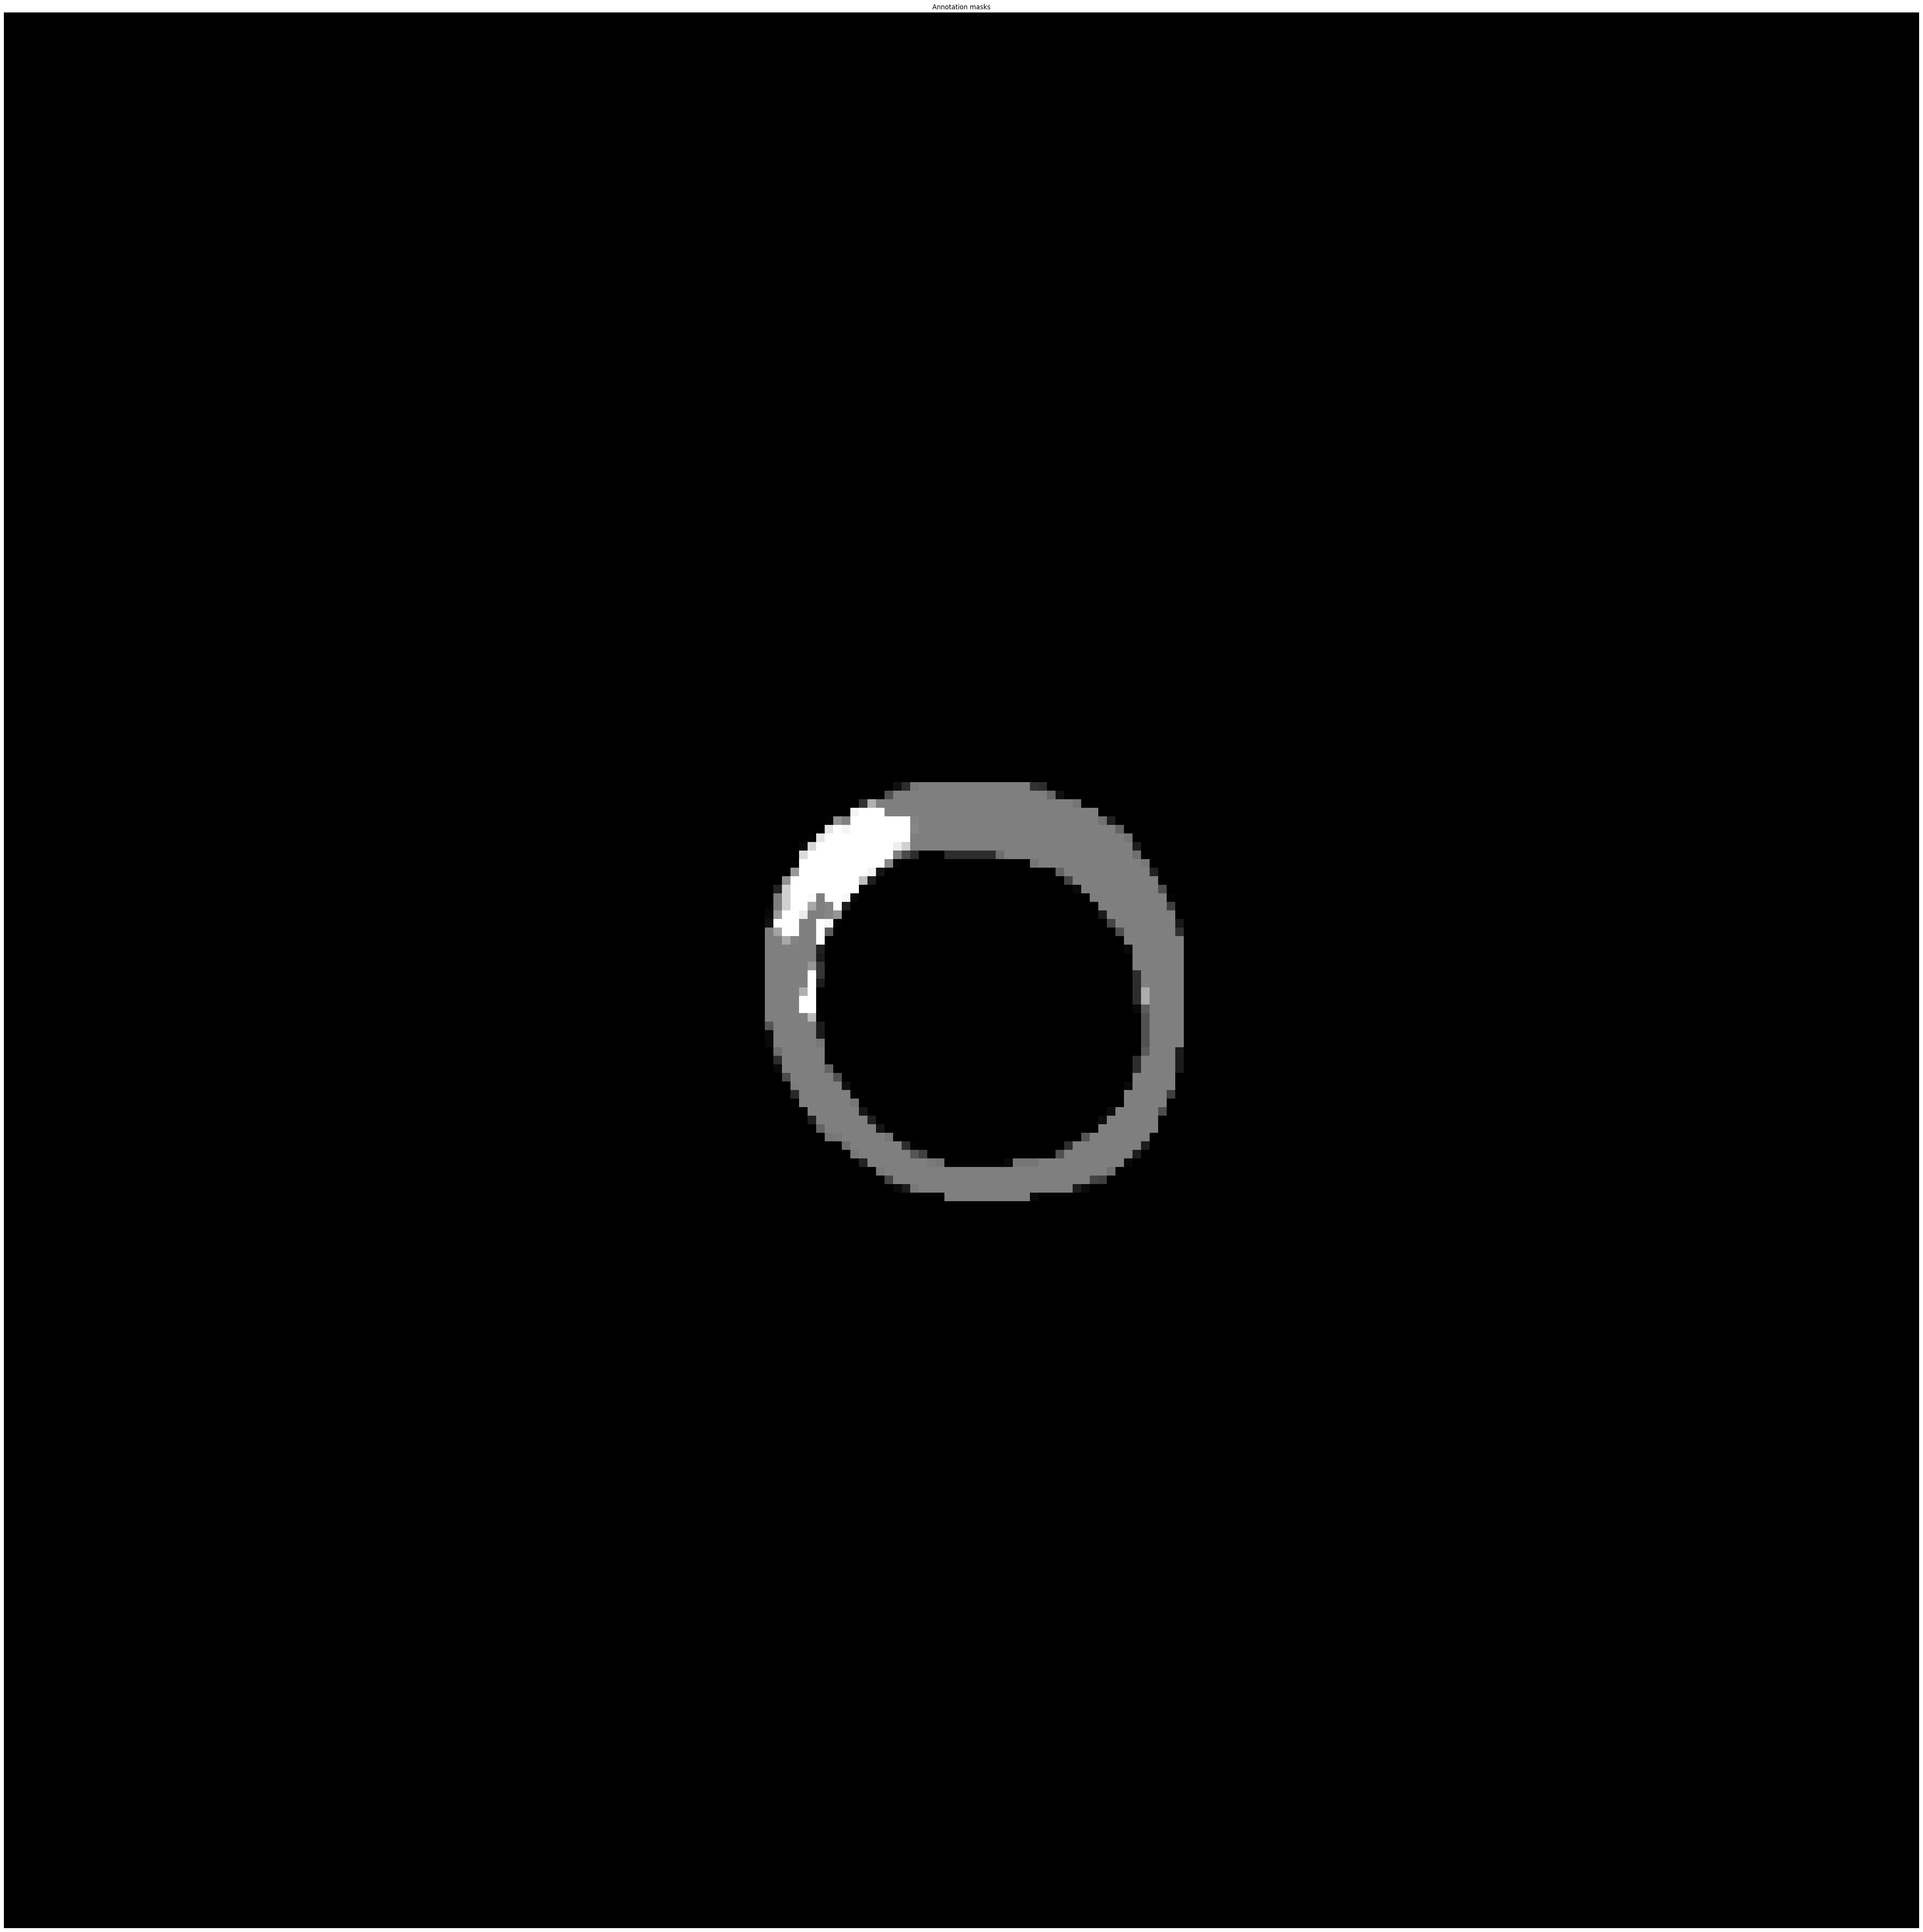

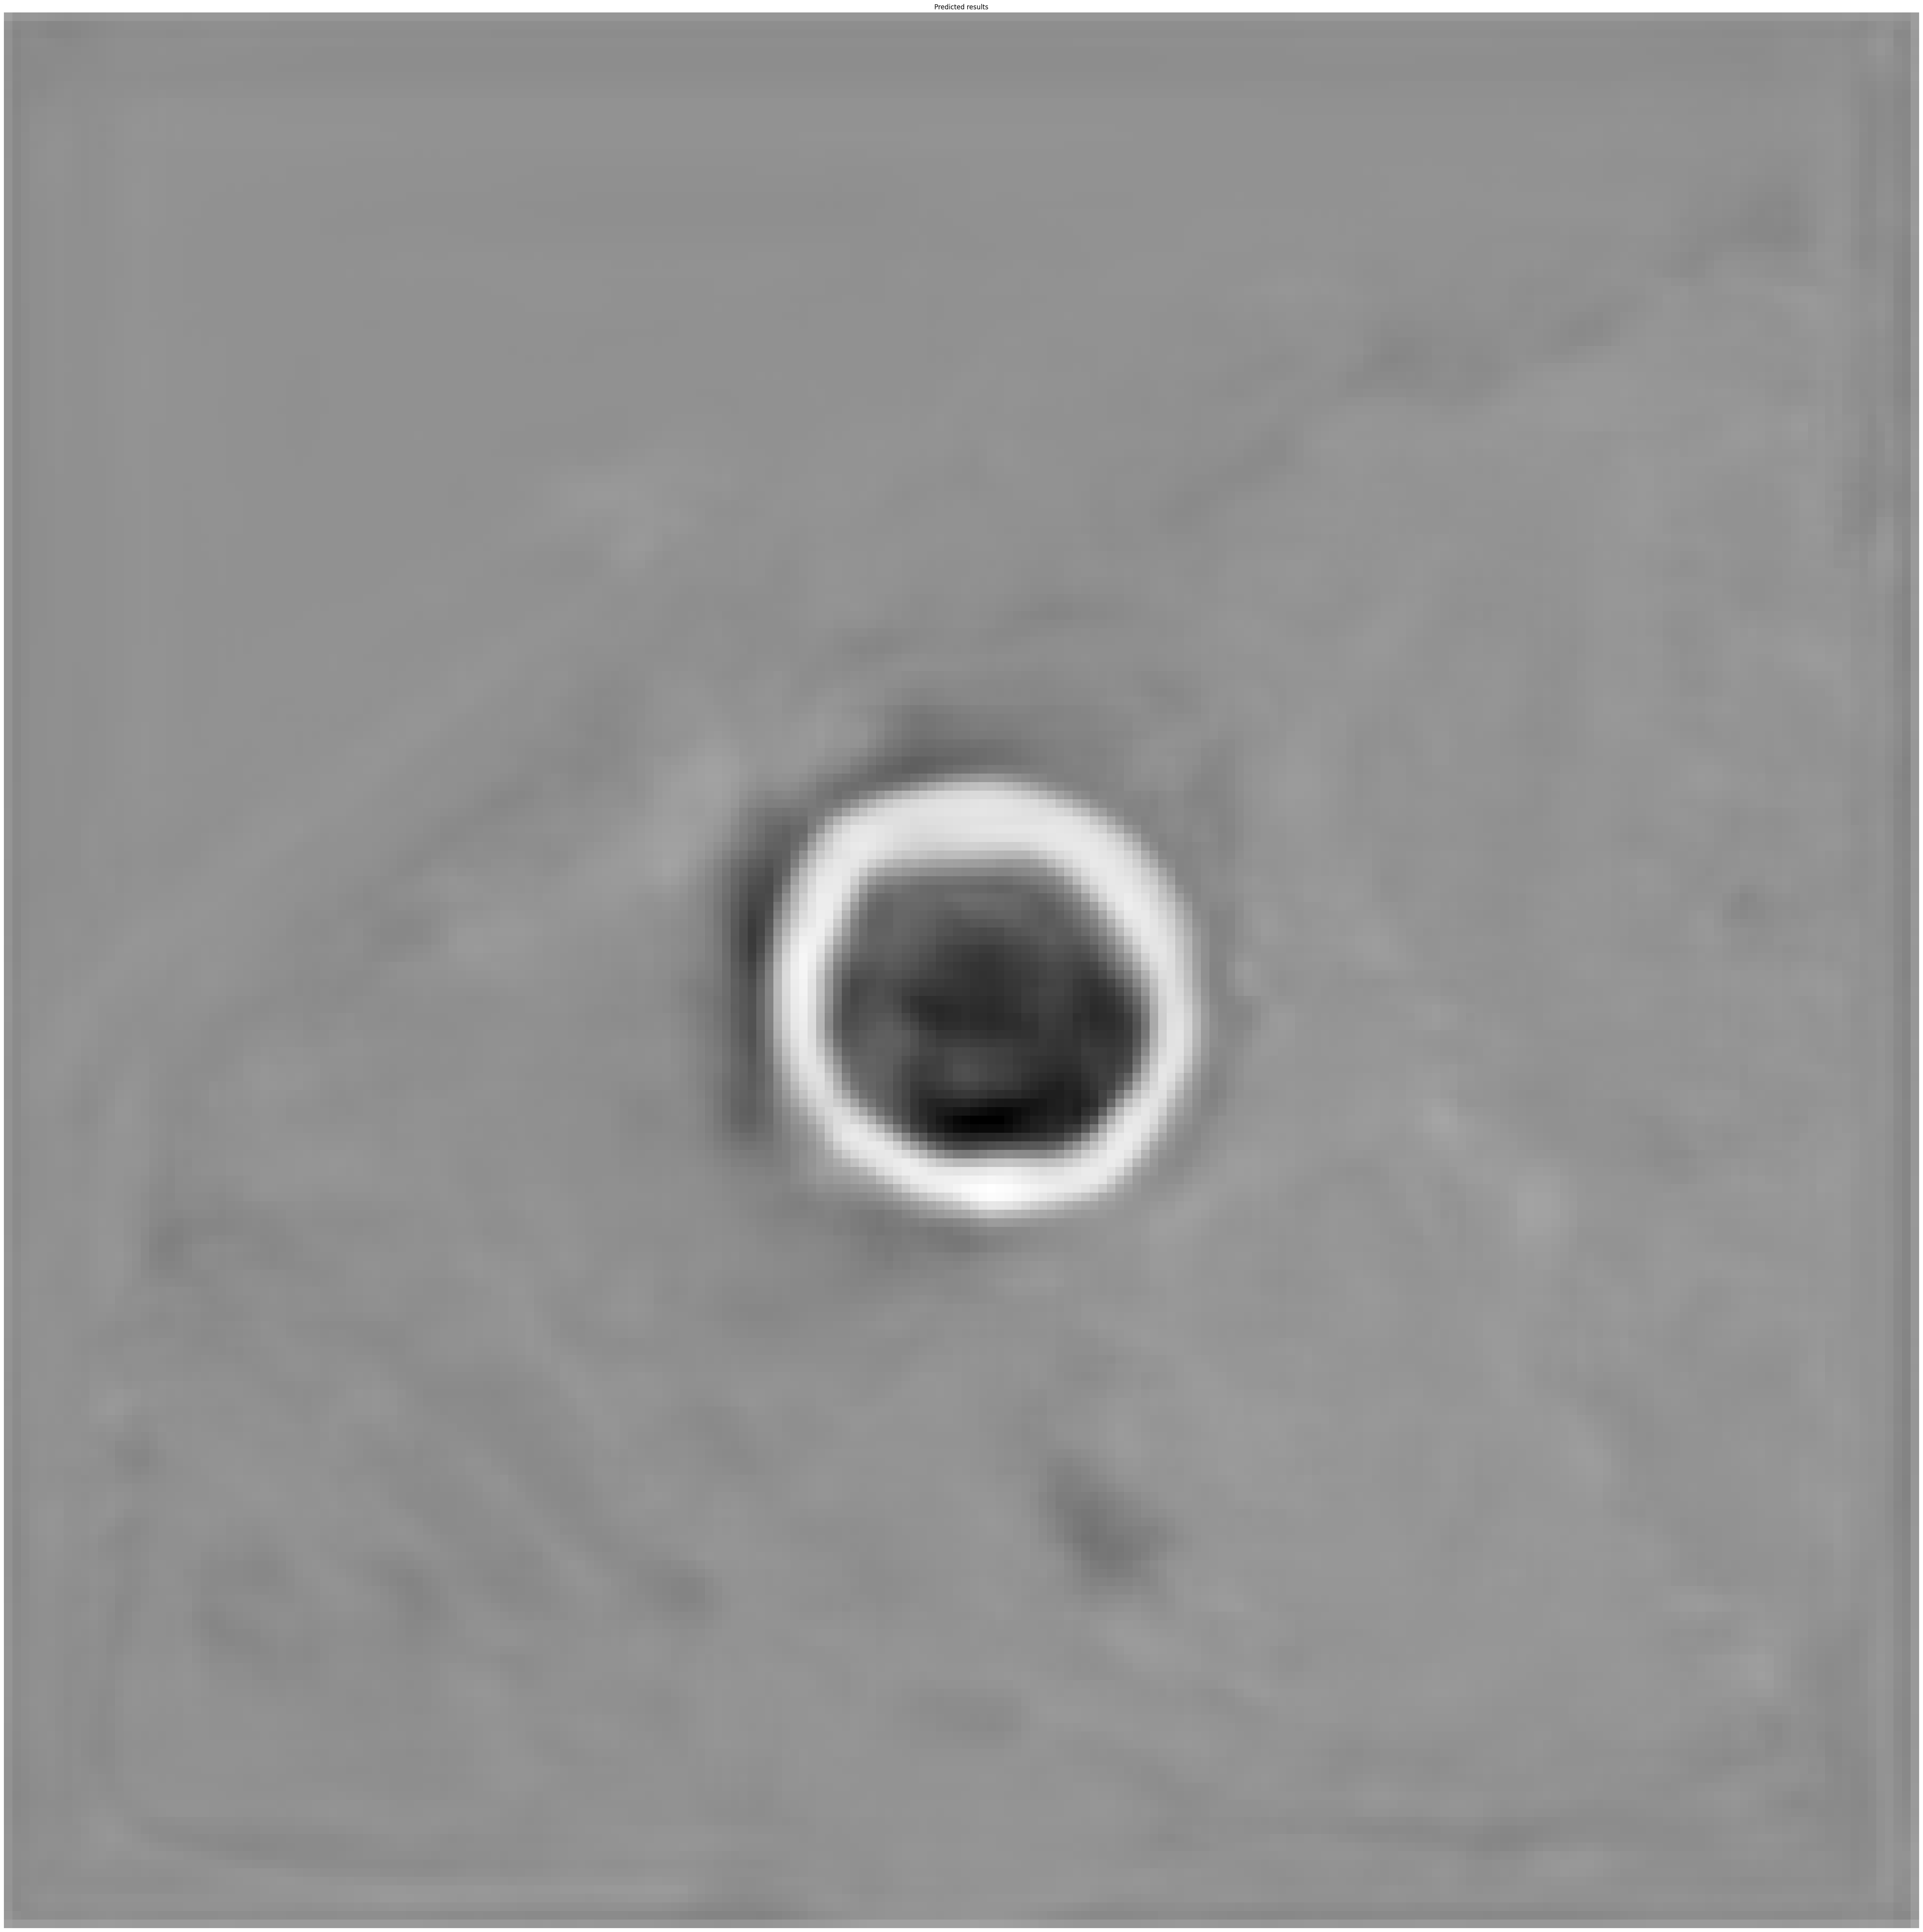

In [ ]:
#Visualizations

# plt.figure(figsize=(64,64))
# plt.axis("off")
# plt.title("Testing Images")
# plt.imshow(np.transpose(vutils.make_grid(img[0:], padding=2, normalize=True).cpu(),(1,2,0)))
# fig = plt.imshow(np.transpose(vutils.make_grid(img[0:], padding=2, normalize=True).cpu(),(1,2,0)))
# ##fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Testing Images V1.png", dpi=224)

# In[15]: show mask


plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Annotation masks")
plt.imshow(np.transpose(vutils.make_grid(mask[0:], padding=2, normalize=True).cpu(),(1,2,0)))
fig = plt.imshow(np.transpose(vutils.make_grid(mask[0:], padding=2, normalize=True).cpu(),(1,2,0)))
#fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Annotation masks V1.png", dpi=224)


# In[19]: show predicted results
# here we have to use mask_pre[0:,1].unsqueeze(1) - select 2nd channel as mask output and add one more dimension for 16,1,224,224 for image display

plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Predicted results")
plt.imshow(np.transpose(vutils.make_grid(mask_pre[0:,1].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
fig = plt.imshow(np.transpose(vutils.make_grid(mask_pre[0:,1].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
#fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Predicted results V1.png", dpi=224)


In [ ]:
#In use for colab, downgrade pandas for later evaluation code
!pip3 install pandas==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
#Import libraries
import os
import numpy as np
import pandas as pd

# specify the folder path for testing dataset
directory = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine'

# number of file in directory
dirListing = os.listdir(directory)
row_num = len(dirListing)

# load empty excel file for recording filename
df = pd.read_csv(
    "/content/drive/My Drive/Internship_24_Ryan/Heart/Temp/Filename.csv")




#Most of the below code from 'for i in range(row_num)' to 'df_final.to_csv' is outdated and reduntant - don't believe its actually useful later"

# add blank row to df for saving ID

for i in range(row_num):
    df = df.append({'ID': i}, ignore_index=True)
df_temp = df

# write ID to final excel file
df_final = df_temp
counter = 0
for filename in os.listdir(directory):
    if filename.endswith(".tiff"):
        df_final['ID'][counter] = filename
        counter += 1

        continue
    else:
        continue

df_final.to_csv(
    '/content/drive/My Drive/Internship_24_Ryan/Heart/Temp/Filename filled.csv',
    index=False)

<ipython-input-33-bfe57870d741>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-33-bfe57870d741>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-33-bfe57870d741>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-33-bfe57870d741>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-33-bfe57870d741>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

In [ ]:
from types import NoneType

# total number of testing dataset
length = df['ID'].size

# other customized DICE calculation fuction - not in use
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true) == 0) and (np.sum(y_pred_bin) == 0):
        return 1
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

# other customized DICE calculation fuction - not in use
def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width, n_channels)
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for j in range(channel_num):
        channel_dice = single_dice_coef(y_true[:, :, j], y_pred_bin[:, :, j])
        mean_dice_channel += channel_dice / (channel_num)
    return mean_dice_channel

# standard DICE calculation fuction
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union == 0:
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
    score = 2. * intersection / union
    #print(score)
    return 2. * intersection / union



In [ ]:
#Import libraries
from scipy.stats import logistic
import gc

#Define variables for average dice coefficient score
score_1 = 0
count = 0
i = 0
lst = []


#Define the total amount of accuracy for each of the labels and the count of each label for individual label accuracy
label_1 = 0
label_2 = 0
label_3 = 0
count_1 = 0
count_2 = 0
count_3 = 0



#Define paths for the test images
img_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
mask_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

#Define testing dataset
test_set_phx = My_Datasets(img_path_test, mask_path_test, transform1=transforms_img, transform2=transforms_mask, frames = 5, select_frame_method = 'specific')
n_test = len(test_set_phx)
test_loader_phx = Data.DataLoader(dataset=test_set_phx,num_workers=0,batch_size=1,pin_memory=True)

#Calculate avg dice score and individual label dice score
for i, (image, mask, filename) in enumerate(test_loader_phx):

    #Send images and masks to GPU
    img = image.to(device=device,dtype=torch.float32)
    mask = mask.to(device=device,dtype=torch.float32)

    #Predict on images and apply softmax function for multiclass segmentation
    with torch.no_grad():
        model_test.eval()
        img = img.permute(1, 0, 2, 3, 4)
        pre = model_test(img.cuda())
        pred = torch.softmax(pre, dim = 1)



    if type(pred) != type(None) and type(mask) != type(None):
      img_score = 0


      for layer in range(3):

        #The model returns an output of shape (4,224,224), with each of the channels being one label's prediction. For example, pred[2] defines the area that the model thinks belongs to Label 2
        #However, the mask is shape (1,224,224), with the different labels simply having different values, with the area of Label 2 being all the pixels that have value 2
        #Label 0 is the background label, the non-disease label, so we do not use it in our evaluation of the dice score

        #Get the ground truth area of the label the for loop is currently on
        temp_mask = np.where(mask.cpu().numpy() == layer+1, 1, 0)

        #Each of the if statements allows a different threshold for each of the layers
          ##Get the predicted area of the label the for loop is currently on
        if layer == 0:
          temp_pred = pred.squeeze(0).cpu().numpy()
          temp_pred = np.where(temp_pred[layer+1] > 0.8, 1, 0)
        elif layer == 1:
          temp_pred = pred.squeeze(0).cpu().numpy()
          temp_pred = np.where(temp_pred[layer+1] > 0.4, 1, 0)
        elif layer == 2:
          temp_pred = pred.squeeze(0).cpu().numpy()
          temp_pred = np.where(temp_pred[layer+1] > 0.4, 1, 0)

        #Calculate the dice score
        score_temp = dice_coef2(temp_mask, temp_pred)

        #Add the dice score to the sum of the scores
        img_score += score_temp

        #If the label is 1, add it to the dice score sum for layer 1 and add one to the number of files that have label 1
        #Continue for all labels

        #Remember that if layer == 0, that means the Label is 1
        #Label 0 is the background layer, and Label 1-3 are heart disease labels
        #The for loop goes through each label, so if the label the for loop is currently on satisfies one of the if statements, add that score to the label's score
        if layer == 0:
          label_1 += score_temp
          count_1 += 1
        elif layer == 1:
          label_2 += score_temp
          count_2 += 1
        elif layer == 2:
          label_3 += score_temp
          count_3 += 1

      #Divide the image score by 3 for each of the labels
      final_img_score = img_score/3

      #Add it to a list
      lst += [[final_img_score, df['ID'][i]]]

      #Add final_img_score to score_1, which is the current avg dice coefficient across all images
      score_1 = score_1 + final_img_score
      count += 1
    else:
      print(i)


print("Dice Coefficient", score_1/count)
print("Label 1 score: ", label_1/count_1)
print("Label 2 score: ", label_2/count_2)
print("Label 3 score: ", label_3/count_3)

Dice Coefficient 0.6010204565704945
Label 1 score:  0.7208957685850055
Label 2 score:  0.4583434288354207
Label 3 score:  0.6238221722910576


In [ ]:
plt.imshow(pred.cpu().squeeze(0)[2])

In [ ]:
plt.imshow(pred.cpu().squeeze(0)[1].rot90(1))

In [ ]:
plt.imshow(mask.cpu()[0].permute(1,2,0))

In [ ]:
plt.imshow(img.cpu()[0][0].permute(1,2,0))

In [ ]:
pred.unsqueeze(0).shape

In [ ]:
pred.shape

In [ ]:
pre[0] == pre.unsqueeze(0)

In [ ]:
temp_pred.shape

In [ ]:
pre[0].shape

In [ ]:
from scipy.stats import logistic
import gc

score_1 = 0
count = 0
i = 0
lst = []



label_1 = 0
label_2 = 0
label_3 = 0
count_1 = 0
count_2 = 0
count_3 = 0



# In[23]: loading test dataset for phx seg

# here we have certain amount of test images
img_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
mask_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

test_set_phx = My_Datasets(img_path_test, mask_path_test, transform1=transforms_img, transform2=transforms_mask)
n_test = len(test_set_phx)
test_loader_phx = Data.DataLoader(dataset=test_set_phx,num_workers=0,batch_size=1,pin_memory=True)

# In[24]: Phx segmentation on lung cropped image, to plot and show every single image and write classification to excel

for i, (image, mask, filename) in enumerate(test_loader_phx):
    img = image.to(device=device,dtype=torch.float32)
    mask = mask.to(device=device,dtype=torch.float32)

    with torch.no_grad():
        model_test.eval()
        img = img.permute(1, 0, 2, 3, 4)
        pre = model_test(img.cuda())

        pred = torch.softmax(pre, dim = 1)



    if type(pred) != type(None) and type(mask) != type(None):
      img_score = 0
      for layer in range(3):
        temp_mask = np.where(mask.cpu().numpy() == layer+1, layer+1, 0)

        if layer == 0:
          temp_pred = np.where(pre[0][layer+1].cpu().numpy() > 0.7, 1, 0)
        elif layer == 1:
          temp_pred = np.where(pre[0][layer+1].cpu().numpy() > 0.5, 2, 0)
        elif layer == 2:
          temp_pred = np.where(pre[0][layer+1].cpu().numpy() > 0.5, 3, 0)

        score_temp = dice_coef2(temp_mask, temp_pred)
        img_score += score_temp

        if layer == 0:
          label_1 += score_temp
          count_1 += 1
        elif layer == 1:
          label_2 += score_temp
          count_2 += 1
        elif layer == 2:
          label_3 += score_temp
          count_3 += 1


      final_img_score = img_score/3


      lst += [[final_img_score, df['ID'][i]]]

        #if score_temp_1 < 0.5:
          #print(i)
        #print(score_temp_1)
      score_1 = score_1 + final_img_score
      count += 1
    else:
      print(i)


    # classification results
    # label_value = torch.max(pred)
    # if label_value > 0.5:
    #     label = 1
    # else:
    #     label = 0
    # df_final['Label'][i] = label

    # gc.collect()
print("Dice Coefficient", score_1/count)
print("Label 1 score: ", label_1/count_1)
print("Label 2 score: ", label_2/count_2)
print("Label 3 score: ", label_3/count_3)

In [ ]:
pre.shape

In [ ]:
plt.imshow(img[0][0].permute(1,2,0))

In [ ]:
plt.imshow(mask[0].permute(1,2,0))

In [ ]:
plt.imshow(pre.cpu()[0][0])

In [ ]:
  pre.shape

In [ ]:
0.556LGE_test_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/LGE/'
cine_test_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
ground_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

test_set = My_Datasets(cine_test_path,ground_test, transform1=transforms_img,transform2=transforms_mask)

In [ ]:
from operator import itemgetter
lst = sorted(lst, key=itemgetter(0))
lst = [[round(pair[0], 3), pair[1]] for pair in lst]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i in range(3):
  #change index here
  index = (i)+50

  name = lst[index][1]
 # here we load as RBG
  cine = test_set[index][0] # here we load as RBG

  gro_mask= test_set[index][1] # here we load as RBG



  pred_mask = model_test(cine.unsqueeze(0))

  axes[i].imshow(pred_mask)
  axes[i].axis('off')  # Hide axis
  #axes[i].set_title(f"Accuracy: {lst[inverse][0]}")